In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
df = pd.read_csv("/kaggle/input/steam-games-dataset-2025/steam_games.csv")

## **(1) Opis zbioru danych**

In [3]:
print("Rozmiar zbioru danych:", df.shape)
print("\nLiczba braków danych:\n", df.isnull().sum())
print("\nTypy zmiennych:\n", df.dtypes)

Rozmiar zbioru danych: (71429, 21)

Liczba braków danych:
 steam_appid            0
name                   0
developers             0
publishers             0
categories             0
genres                 0
required_age           0
n_achievements         0
platforms              0
is_released            0
release_date           0
additional_content     0
total_reviews          0
total_positive         0
total_negative         0
review_score           0
review_score_desc      0
positive_percentual    0
metacritic             0
is_free                0
price_initial (USD)    0
dtype: int64

Typy zmiennych:
 steam_appid              int64
name                    object
developers              object
publishers              object
categories              object
genres                  object
required_age             int64
n_achievements           int64
platforms               object
is_released               bool
release_date            object
additional_content      object
total_reviews

## **(2) Statystyki opisowe zmiennych numerycznych**

In [4]:
num_cols = df.select_dtypes(include=[np.number]).columns
print("\nStatystyki opisowe:\n", df[num_cols].describe())


Statystyki opisowe:
         steam_appid  required_age  n_achievements  total_reviews  \
count  7.142900e+04  71429.000000    71429.000000   7.142900e+04   
mean   1.613700e+06      2.573227       16.079478   4.102497e+02   
std    8.625559e+05     13.591997      138.084319   8.389934e+03   
min    7.300000e+02      0.000000        0.000000   0.000000e+00   
25%    9.296400e+05      0.000000        0.000000   0.000000e+00   
50%    1.533470e+06      0.000000        0.000000   2.000000e+00   
75%    2.383530e+06      0.000000       16.000000   1.900000e+01   
max    3.430140e+06     97.000000     9821.000000   1.279700e+06   

       total_positive  total_negative  review_score  positive_percentual  \
count    7.142900e+04    71429.000000  71429.000000         71429.000000   
mean     3.602238e+02       50.025886      2.192849            46.113290   
std      7.409672e+03     1171.055349      3.175885            41.961702   
min      0.000000e+00        0.000000      0.000000          

### WNIOSKI:
Większość gier w zbiorze ma bardzo mało ocen – mediana liczby recenzji to tylko 2, a aż 75% gier ma mniej niż 20 opinii.
Ponad połowa gier ma zerową cenę początkową, ale zdarzają się też ekstremalnie drogie pozycje (do 999.98 USD).
Oceny użytkowników (positive_percentual) są mocno zróżnicowane, ale mediana wynosi 50%, co wskazuje na względnie neutralny odbiór wielu gier.

## **(3) Analiza grupowa względem zmiennej jakościowej 'is_free'**

In [12]:
numeric_cols = [
    'price_initial (USD)', 'required_age', 'n_achievements',
    'total_reviews', 'total_positive', 'total_negative',
    'review_score', 'positive_percentual', 'metacritic'
]

grouped = df.groupby('is_free')[numeric_cols].mean().round(2)
print(grouped)

         price_initial (USD)  required_age  n_achievements  total_reviews  \
is_free                                                                     
False                   7.53          2.89           17.05         443.81   
True                    0.00          0.55            9.79         192.66   

         total_positive  total_negative  review_score  positive_percentual  \
is_free                                                                      
False            391.72           52.08          2.45                50.80   
True             155.98           36.68          0.52                15.71   

         metacritic  
is_free              
False          2.89  
True           0.55  


### WNIOSKI:
Płatne gry mają średnio ponad dwa razy więcej recenzji i osiągają znacznie wyższy odsetek pozytywnych ocen (50,8%) niż gry darmowe (15,7%).
Darmowe gry są zazwyczaj skierowane do młodszych graczy (średni wymagany wiek to tylko 0,55 roku) i cechują się niższą jakością odbieraną przez użytkowników.

## **(4) Analiza zmiennej multilabel 'genres'**

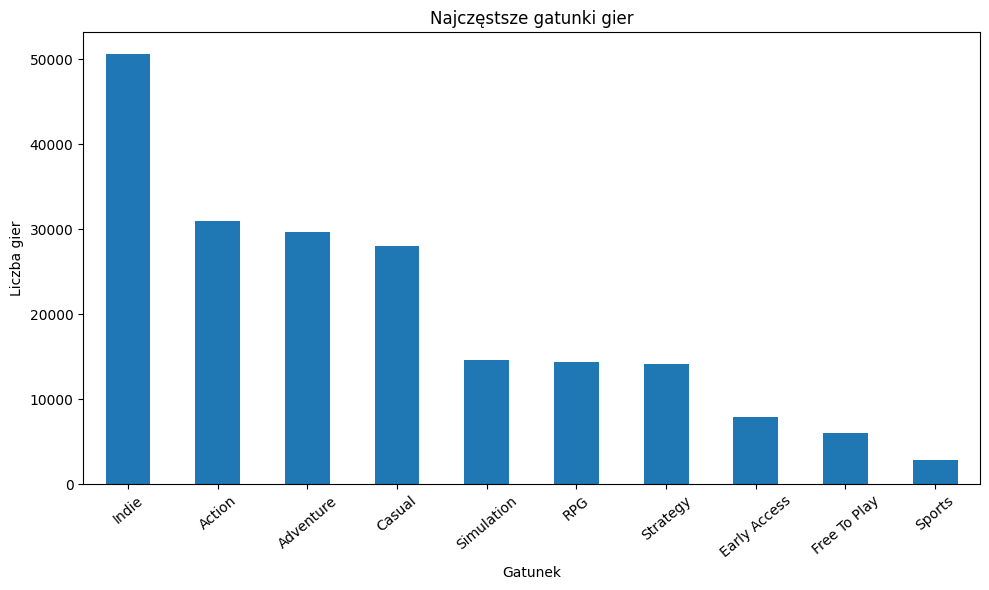

In [13]:
df['genre_clean'] = df['genres'].dropna().astype(str) \
    .str.replace(r"[\[\]\'\"]", "", regex=True) \
    .str.strip()

df['genre_split'] = df['genre_clean'].apply(lambda x: x.split(', ') if pd.notnull(x) else [])

all_genres = [g for sublist in df['genre_split'] for g in sublist]
genre_counts = Counter(all_genres)

plt.figure(figsize=(10,6))
pd.Series(genre_counts).sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Najczęstsze gatunki gier')
plt.xlabel('Gatunek')
plt.ylabel('Liczba gier')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

### WNIOSKI:
Najpopularniejszym gatunkiem gier na platformie Steam są gry niezależne (Indie), które wyraźnie przeważają nad innymi gatunkami. Dużą popularnością cieszą się też gry akcji, przygodowe i casualowe, czyli takie, które łatwo zacząć i dają szybką rozrywkę.

## **(5) Zależności między zmiennymi**

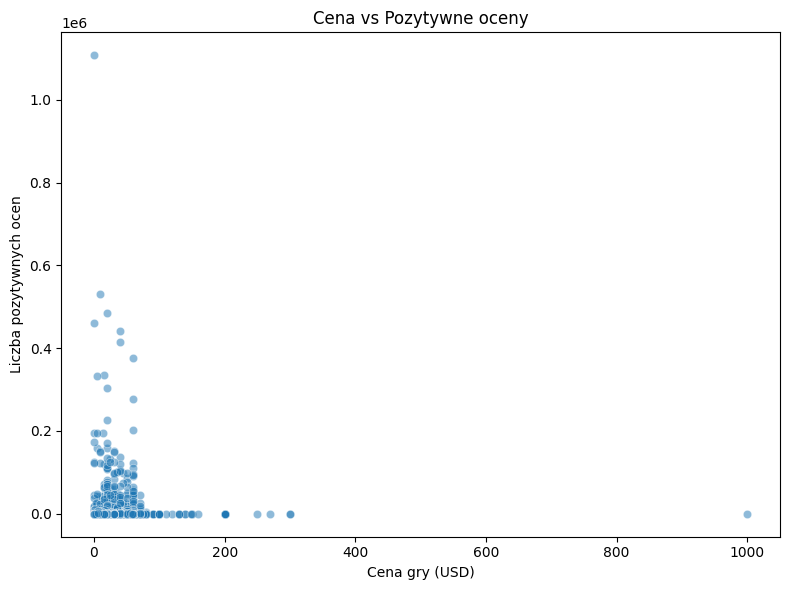

In [8]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="price_initial (USD)", y="total_positive", alpha=0.5)
plt.title("Cena vs Pozytywne oceny")
plt.xlabel("Cena gry (USD)")
plt.ylabel("Liczba pozytywnych ocen")
plt.tight_layout()
plt.show()

### WNIOSKI:
Na wykresie widać, że najwięcej pozytywnych ocen zbierają gry tanie lub całkowicie darmowe. Wysoka cena nie przekłada się na większą liczbę opinii – wręcz przeciwnie, najdroższe gry są oceniane bardzo rzadko. Oznacza to, że popularność gry zależy bardziej od dostępności niż od ceny.

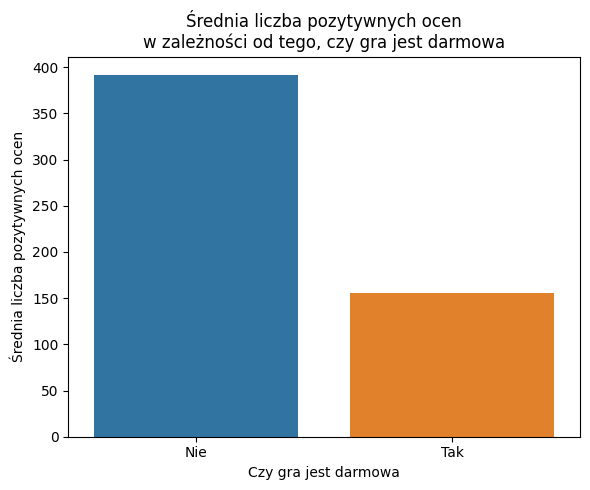

In [11]:
# Przygotowanie danych: średnia liczba pozytywnych ocen w grupach
avg_positive = df.groupby('is_free')['total_positive'].mean().reset_index()
avg_positive['is_free'] = avg_positive['is_free'].map({True: "Tak", False: "Nie"})

# Wykres słupkowy
plt.figure(figsize=(6,5))
sns.barplot(data=avg_positive, x='is_free', y='total_positive')
plt.title("Średnia liczba pozytywnych ocen\nw zależności od tego, czy gra jest darmowa")
plt.xlabel("Czy gra jest darmowa")
plt.ylabel("Średnia liczba pozytywnych ocen")
plt.tight_layout()
plt.show()

### WNIOSKI:
Gry płatne średnio otrzymują znacznie więcej pozytywnych ocen niż gry darmowe.
To może sugerować, że płatne gry częściej są bardziej dopracowane i darmowe gry mogą być częściej porzucane lub oceniane rzadziej.
Warto jednak uwzględnić, że dane mogą być zaburzone przez obecność bardzo popularnych, komercyjnych hitów wśród gier płatnych.